In [ ]:
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 57.7 MB/s eta 0:00:00


In [ ]:
!pip install tqdm

In [ ]:
!pip install tensorflow

In [ ]:
from PIL import Image
import os
import cv2
import imagehash
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from tqdm import tqdm
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

In [ ]:
image_folder = "/content/train/images"
label_folder = "/content/train/labels"
valid_folder = "/content/valid/images"
# class_file = "train/classes.txt"

## DATA CLEANING

In [ ]:
# Removes corrupt images from a directory
def remove_corrupt_images(folder_path):
  for filename in os.listdir(folder_path):
    try:
      img = Image.open(os.path.join(folder_path, filename))
      img.verify()
      print(f'Verification success')
    except (IOError, SyntaxError) as e:
      os.remove(os.path.join(folder_path, filename))
      print(f'Removed corrupt image: {filename}')

In [ ]:
remove_corrupt_images(image_folder)

In [ ]:
# Resize all images to the target size
def standardize_image_size(folder_path, target_size=(224, 224)):
  for filename in os.listdir(folder_path):
    img_path = os.path.join(folder_path, filename)
    img = cv2.imread(img_path)
    if img is not None:
      resized_img = cv2.resize(img, target_size)
      print(resized_img.shape)
      cv2.imwrite(img_path, resized_img)

In [ ]:
standardize_image_size(image_folder)

In [ ]:
# Remove duplicates
def remove_duplicates_images(folder_path):
    """Removes duplicate images based on perceptual hash and prints the number of duplicates."""
    hashes = set()
    duplicate_count = 0

    # First pass: Count the number of duplicates
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img_hash = imagehash.average_hash(Image.open(img_path))
        if img_hash in hashes:
            duplicate_count += 1  # Increment the duplicate counter
        else:
            hashes.add(img_hash)

    # Print the number of duplicates found
    print(f"Number of duplicates found: {duplicate_count}")

    # Second pass: Remove the duplicates
    hashes = set()  # Reset the set for the second pass
    removed_count = 0  # Counter to track the number of duplicates removed

    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img_hash = imagehash.average_hash(Image.open(img_path))
        if img_hash in hashes:
            print(f"Removing duplicate image: {filename}")
            os.remove(img_path)
            removed_count += 1  # Increment the removed counter
        else:
            hashes.add(img_hash)

    # Print the number of duplicates removed
    print(f"Number of duplicates removed: {removed_count}")

In [ ]:
remove_duplicates_images(image_folder)

In [ ]:
# normaalizes pixes values to the range [0, 1]
def normalize_images(folder_path):
    """Normalizes pixel values to the range [0, 1] and displays the normalized pixel values."""
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
            # Normalize the image to the range [0, 1]
            normalized_img = img.astype(np.float32) / 255.0

            print(normalized_img[:50])

            # Save the normalized image (scaled back to [0, 255])
            cv2.imwrite(img_path, (normalized_img * 255).astype(np.uint8))

In [ ]:
normalize_images(image_folder)

In [ ]:
#Convers grayscale images to RGB format.
def convert_grayscale_to_rgb(folder_path):
    """Converts grayscale images to RGB format and displays them."""
    from google.colab.patches import cv2_imshow # Import cv2_imshow from google.colab.patches

    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None and len(img.shape) == 2:
            # Convert grayscale to RGB
            img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

            # Display the converted image using cv2_imshow instead of cv2.imshow
            cv2_imshow(img_rgb)
            #cv2.imshow(f"Converted Image: {filename}", img_rgb)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

            # Save the converted image
            cv2.imwrite(img_path, img_rgb)

In [ ]:
convert_grayscale_to_rgb(image_folder)

In [ ]:
def convert_rgb_to_grayscale(folder_path):
    """
    Converts RGB images to grayscale format.

    Args:
        folder_path (str): Path to the directory containing RGB images.
    """
    # Loop through all files in the directory
    for filename in os.listdir(folder_path):
        # Construct the full path to the image
        img_path = os.path.join(folder_path, filename)

        # Read the image
        img = cv2.imread(img_path)

        # Check if the image was successfully read and is RGB
        # RGB images have 3 dimensions
        if img is not None and len(img.shape) == 3:
            # Convert the image to grayscale
            grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Save the grayscale image, overwriting the original
            cv2.imwrite(img_path, grayscale_img)
            print(f"Converted {filename} to grayscale.")
        else:
            print(f"Skipping {filename}: Not a valid RGB image.")

In [ ]:
convert_rgb_to_grayscale(image_folder)

In [ ]:
# Checking if any images are missing corresponding to labels
# Removing images with missing lables
def check_missing_images(folder_path, labels_folder):
    """Checks if any images are missing corresponding labels and removes those images."""
    # Get base filenames without extensions for images and labels
    image_files = {os.path.splitext(filename)[0] for filename in os.listdir(folder_path)}
    label_files = {os.path.splitext(filename)[0] for filename in os.listdir(labels_folder)}

    # Find images without corresponding labels
    missing_labels = image_files - label_files
    if missing_labels:
        print(f"Missing labels: {missing_labels}")
        # Remove images with missing labels
        for missing_label in missing_labels:
            # Construct the full path to the image file
            image_path = os.path.join(folder_path, f"{missing_label}.jpg")  # Adjust extension if needed
            if os.path.exists(image_path):
                os.remove(image_path)
                print(f"Removed image: {image_path}")
            else:
                print(f"Image not found: {image_path}")
    else:
        print("No missing labels found.")

In [ ]:
check_missing_images(image_folder, label_folder)

Missing labels: {'IMG_0214_JPG.rf.ff901d83bb7227dd3800eed1eb0aa6dc', 'IMG_0330_JPG.rf.745cebf4e282b04cb36dd50cdad81f94', 'IMG_1145_JPG.rf.e660dc4161e55a9d5e9ae4339cb033be', 'IMG_0213_JPG.rf.c3d06634ba033bc2aa45b4196177733f', 'IMG_0213_JPG.rf.6ae88337d39608b8566aa7a0a3c042df', 'IMG_0214_JPG.rf.4ed66c48b590e58096cb5bdd7007ef31', 'IMG_1145_JPG.rf.c501a5873b27b49a7a67bebc42bf9bdb', 'IMG_1145_JPG.rf.73bb1c1d25d5dea40cf9b10b9f18bca3', 'IMG_1144_JPG.rf.8da9645619107724e73213f099f6ea98', 'IMG_1144_JPG.rf.8a8440c10b4ca467478b0f9285202c46', 'IMG_1143_JPG.rf.73a319d7c2648598ac74b4a3222f4927', 'IMG_0214_JPG.rf.256ab89188a6a009f654161bcc04fc64'}
Removed image: /content/train/images/IMG_0214_JPG.rf.ff901d83bb7227dd3800eed1eb0aa6dc.jpg
Removed image: /content/train/images/IMG_0330_JPG.rf.745cebf4e282b04cb36dd50cdad81f94.jpg
Removed image: /content/train/images/IMG_1145_JPG.rf.e660dc4161e55a9d5e9ae4339cb033be.jpg
Removed image: /content/train/images/IMG_0213_JPG.rf.c3d06634ba033bc2aa45b4196177733f.jpg

In [ ]:
# Checks class distribution in dataset.
def check_class_imbalance(labels_folder):
  labels = [f.split('_')[0] for f in os.listdir(labels_folder)]
  label_counts = Counter(labels)
  print("Label distribution: ", label_counts)

In [ ]:
check_class_imbalance(label_folder)

Label distribution:  Counter({'IMG': 627})


In [ ]:
# Converts PNG images to JPG format.
def convert_png_to_jpg(folder_path):
    """Converts PNG images to JPG format and displays the names of converted files."""
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            # Construct full path to the PNG file
            png_path = os.path.join(folder_path, filename)

            # Open the PNG image and convert it to RGB
            img = Image.open(png_path)
            img = img.convert("RGB")

            # Construct the new JPG filename and save the image
            jpg_filename = filename.replace(".png", ".jpg")
            jpg_path = os.path.join(folder_path, jpg_filename)
            img.save(jpg_path, "JPEG")

            # Display the name of the converted file
            print(f"Converted: {filename} -> {jpg_filename}")

            # Remove the original PNG file
            os.remove(png_path)

In [ ]:
convert_png_to_jpg(image_folder)

In [ ]:
# Applies data augumentation transformations
def augment_data(folder_path, output_folder): # Added output_folder as a parameter
    """Applies data augmentation transformations, displays images without time limit, and saves augmented images to a new folder."""
    if not os.path.exists(output_folder):  # Create the output folder if it doesn't exist
        os.makedirs(output_folder)

    # Initialize the ImageDataGenerator with augmentation parameters
    datagen = ImageDataGenerator(
        rotation_range=20,       # Randomly rotate images by up to 20 degrees
        width_shift_range=0.2,  # Randomly shift images horizontally by up to 20%
        height_shift_range=0.2, # Randomly shift images vertically by up to 20%
        horizontal_flip=True    # Randomly flip images horizontally
    )

    # Lists to store original and augmented images
    original_images = []
    augmented_images = []

    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)  # Read the image
        if img is not None:
            # Store the original image
            original_images.append((filename, img))

            # Prepare the image for augmentation
            img = np.expand_dims(img, axis=0)  # Add batch dimension

            # Apply data augmentation
            aug_iter = datagen.flow(img, batch_size=1)
            aug_img = next(aug_iter)[0].astype(np.uint8)  # Get the augmented image

            # Store the augmented image
            augmented_images.append((filename, aug_img))

            # Save the augmented image to the output folder
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, aug_img)

    # Display original and augmented images after processing all images
    for (orig_filename, orig_img), (aug_filename, aug_img) in zip(original_images, augmented_images):
        # Display the original image
        cv2.imshow(f"Original: {orig_filename}", orig_img)
        cv2.waitKey(0)  # Wait indefinitely for a key press

        # Display the augmented image
        cv2.imshow(f"Augmented: {aug_filename}", aug_img)
        cv2.waitKey(0)  # Wait indefinitely for a key press

    # Close all OpenCV windows after displaying all images
    cv2.destroyAllWindows()

In [ ]:
augument_data(image_folder)

## Data Exploratory

In [ ]:
labels = [f.split('_')[0] for f in os.listdir(label_folder)]
class_counts = Counter(labels)
plt.figure(figsize=(10, 5))

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

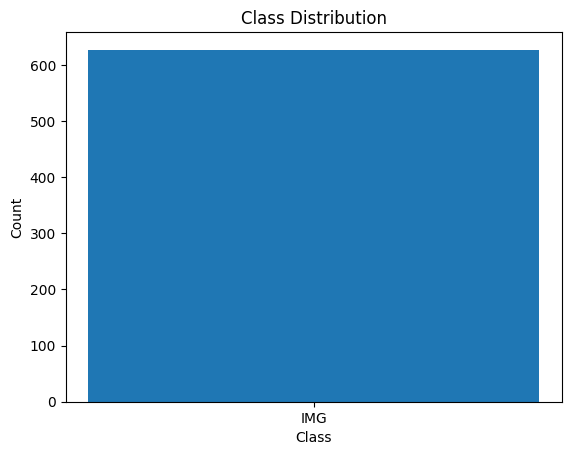

In [ ]:
# Class Distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

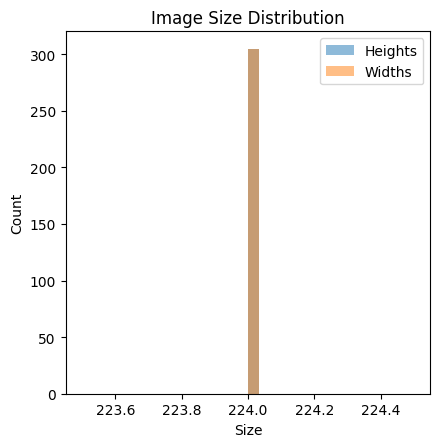

In [ ]:
# Image size Disribution
plt.figure(figsize=(16, 16))
heights, widths = [], []
for filename in os.listdir(image_folder):
    img = cv2.imread(os.path.join(image_folder, filename))
    if img is not None:
        h, w, _ = img.shape
        heights.append(h)
        widths.append(w)
plt.subplot(3, 3, 2)
plt.hist(heights, bins=30, alpha=0.5, label='Heights')
plt.hist(widths, bins=30, alpha=0.5, label='Widths')
plt.xlabel("Size")
plt.ylabel("Count")
plt.title("Image Size Distribution")
plt.legend()

Text(0.5, 1.0, 'Aspect Ratio Distribution')

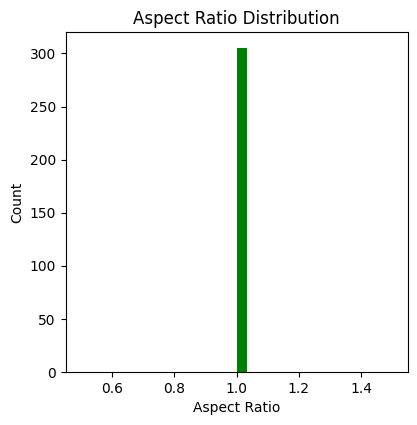

In [ ]:
# Aspect Ratio Distribution
plt.figure(figsize=(15, 15))
plt.subplot(3, 3, 3)
aspect_ratios = [w/h for w, h in zip(widths, heights)]
plt.hist(aspect_ratios, bins=30, color='green')
plt.xlabel("Aspect Ratio")
plt.ylabel("Count")
plt.title("Aspect Ratio Distribution")

Text(0.5, 1.0, 'Mean Image')

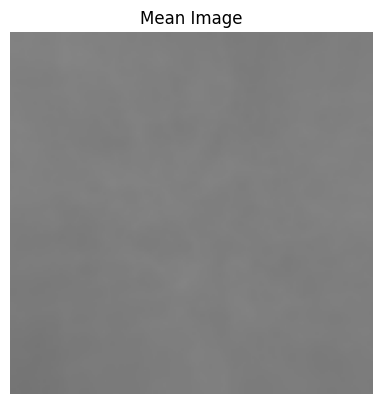

In [ ]:
# Mean Image
plt.figure(figsize=(16, 16))
plt.subplot(3, 3, 4)
mean_image = np.mean([cv2.imread(os.path.join(image_folder, f)).astype(np.float32) for f in os.listdir(image_folder)], axis=0)
plt.imshow(mean_image.astype(np.uint8))
plt.axis("off")
plt.title("Mean Image")

Text(0.5, 1.0, 'Pixel Intensity Distribution')

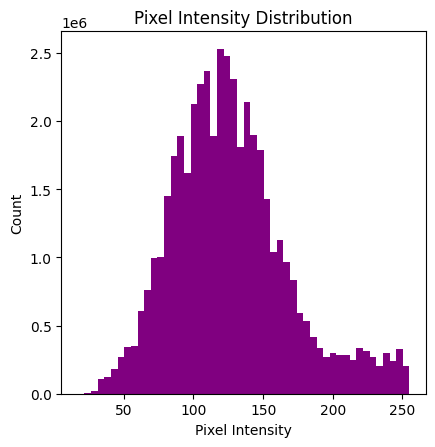

In [ ]:
# Pixel Intensity Distribution
plt.figure(figsize=(16, 16))
plt.subplot(3, 3, 5)
pixel_values = [cv2.imread(os.path.join(image_folder, f)).flatten() for f in os.listdir(image_folder)]
pixel_values = np.concatenate(pixel_values)
plt.hist(pixel_values, bins=50, color='purple')
plt.xlabel("Pixel Intensity")
plt.ylabel("Count")
plt.title("Pixel Intensity Distribution")

Text(0.5, 0.98, 'Sample Images')

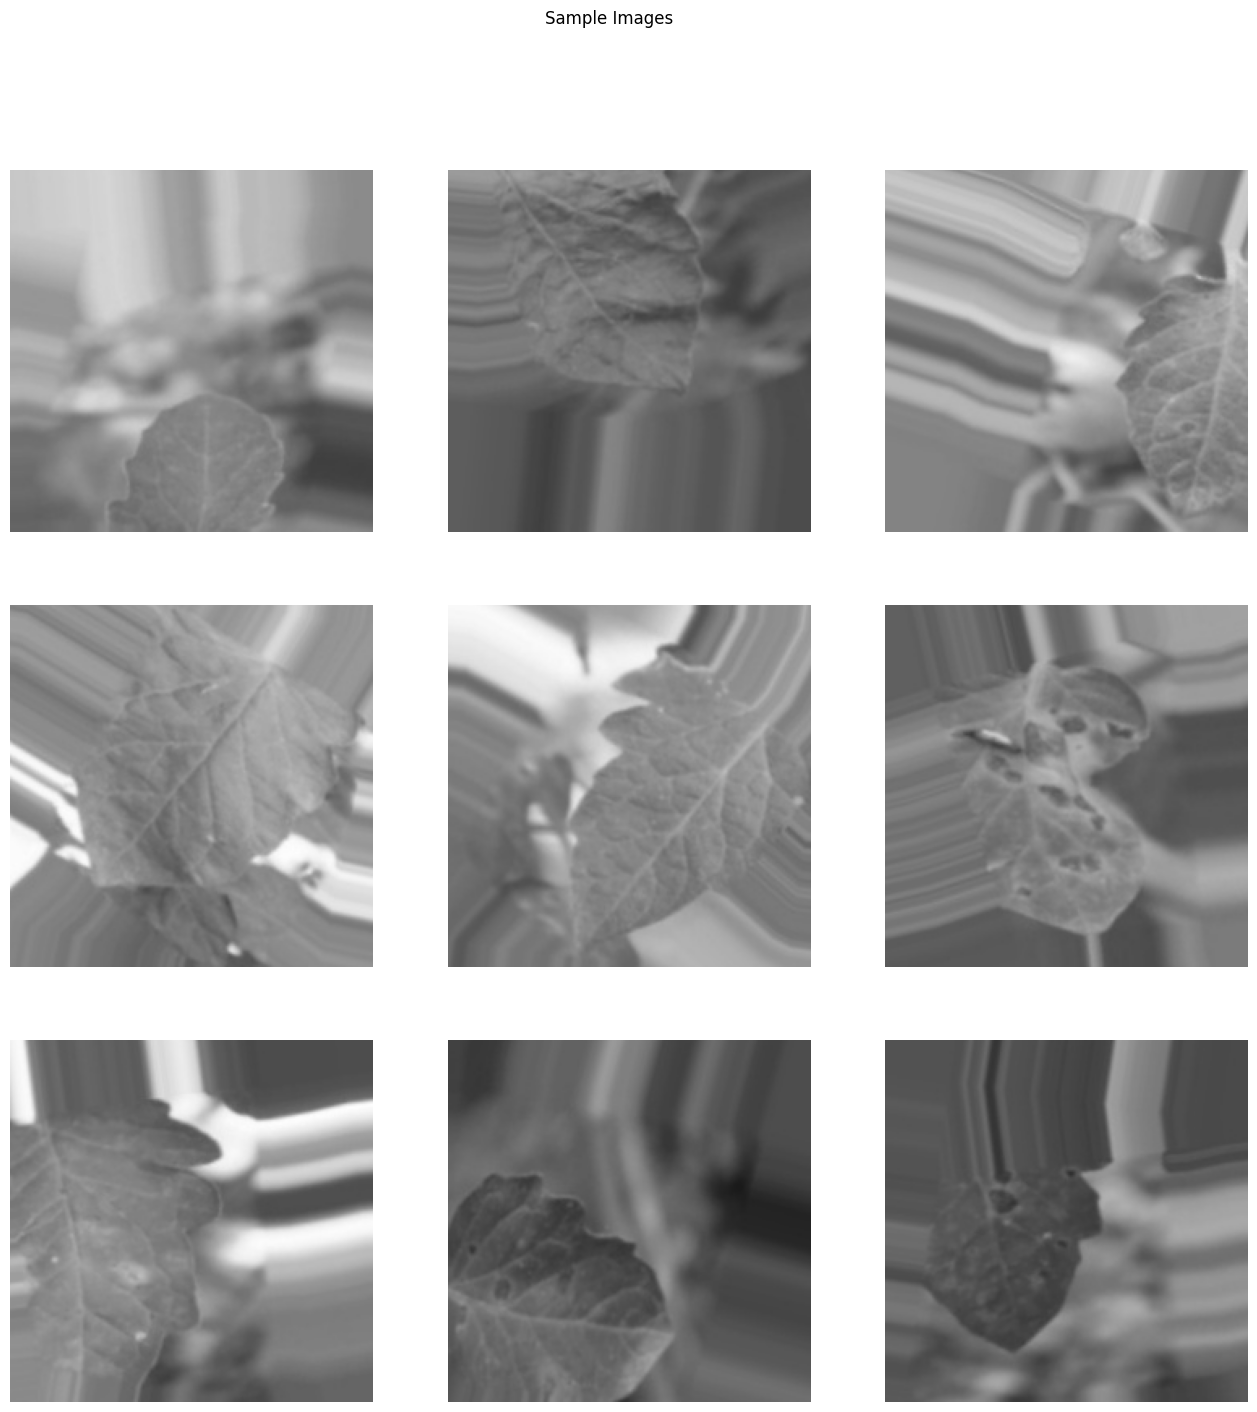

In [ ]:
# Sample Images (Grid)
plt.figure(figsize=(16, 16))
plt.subplot(3, 3, 6)
sample_files = np.random.choice(os.listdir(image_folder), 9, replace=False)
for i, file in enumerate(sample_files):
    plt.subplot(3, 3, i+1)
    img = cv2.imread(os.path.join(image_folder, file))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
plt.suptitle("Sample Images")

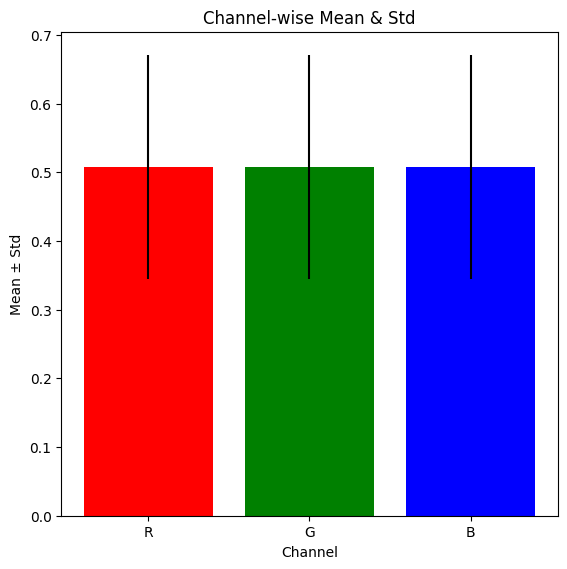

In [ ]:
# Channel-wise Mean & Std
plt.figure(figsize=(16, 16))
plt.subplot(3, 3, 7)
images = [cv2.imread(os.path.join(image_folder, f)).astype(np.float32) / 255.0 for f in os.listdir(image_folder)]
means = np.mean(images, axis=(0, 1, 2))
stds = np.std(images, axis=(0, 1, 2))
plt.bar(["R", "G", "B"], means, yerr=stds, color=["red", "green", "blue"])
plt.xlabel("Channel")
plt.ylabel("Mean ± Std")
plt.title("Channel-wise Mean & Std")

plt.tight_layout()
plt.show()

In [ ]:
def load_class_names(label_path):
    """Loads class names from all .txt files within the label_path."""
    class_names = set()  # Use a set to store unique class names

    for filename in os.listdir(label_path):
        if filename.endswith(".txt"):  # Only process .txt files
            file_path = os.path.join(label_path, filename)
            with open(file_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if parts:  # Check if the line is not empty
                        class_id = parts[0]  # Assuming the first element is the class ID or name
                        class_names.add(class_id)  # Add to the set of class names

    return sorted(list(class_names))  # Convert the set to a sorted list

In [ ]:
def load_dataset(image_folder, label_folder, target_size=(224, 224)):
    """Cleans dataset, matches labels with images, and converts labels to categorical format."""
    # remove_corrupt_images(image_folder)
    # standardize_image_size(image_folder, target_size)
    # remove_duplicates_images(image_folder)
    # normalize_images(image_folder)
    # convert_rgb_to_grayscale(image_folder)

    class_names = load_class_names(label_folder)  # Load class names from all .txt files
    images, labels = [], []

    for label_file in os.listdir(label_folder):
        match = re.match(r"^(.*?)(_rf\..*?)?\.txt$", label_file)  # Extract base name
        if match:
            base_name = match.group(1)
            img_path = os.path.join(image_folder, f"{base_name}.jpg")  # Assume images are .jpg
            if not os.path.exists(img_path):
                continue  # Skip if image not found

            with open(os.path.join(label_folder, label_file), "r") as f:
                lines = f.readlines()
                for line in lines:
                    parts = line.strip().split()
                    class_id = parts[0]  # Extract class ID or name

                    # Check if class_id is in class_names, if not skip
                    if class_id not in class_names:
                        continue

                    # Find the index of class_id in class_names
                    class_index = class_names.index(class_id)

                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, target_size)
                        img = img.astype(np.float32) / 255.0
                        images.append(img)
                        labels.append(class_index)  # Use the index for to_categorical

    images = np.array(images)
    labels = to_categorical(np.array(labels), num_classes=len(class_names))
    return images, labels, class_names

In [ ]:
load_dataset(image_folder, label_folder)

In [ ]:
def build_cnn_model(input_shape, num_classes):
    """Builds and returns a CNN model."""
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
def train_cnn_model(image_folder, label_folder):
    """Loads data, trains the CNN model, and evaluates it."""
    X, y, class_names = load_dataset(image_folder, label_folder)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = build_cnn_model(input_shape=X_train.shape[1:], num_classes=len(class_names))
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    model.fit(X_train, y_train, validation_data=(X_test, y_test),
              epochs=20, batch_size=32, callbacks=[early_stop])

    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_acc:.4f}")

    model.save("cnn_model.h5")
    print("Model saved as cnn_model.h5")

In [ ]:
train_cnn_model(image_folder, label_folder)

In [ ]:
def convert_to_tflite(model_path):
    model = load_model(model_path)
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    with open("cnn_model.tflite", "wb") as f:
        f.write(tflite_model)
    print("Model converted to TensorFlow Lite format.")

In [ ]:
def evaluate_model(model_path, test_image_folder, test_label_folder, class_names):  # Updated parameter name to class_names
    """Loads test images, performs predictions, and evaluates model performance."""
    model = load_model(model_path)

    # Assuming load_dataset can be used to load test data as well
    X_test, y_true, _ = load_dataset(test_image_folder, test_label_folder)

    # Get filenames for display (adjust as needed)
    filenames = [os.path.join(test_image_folder, f) for f in os.listdir(test_image_folder) if f.endswith(".jpg")]

    y_pred_probs = model.predict(X_test)  # Get predicted probabilities
    y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

    # Convert y_true to binary format if it's multilabel-indicator
    if y_true.ndim == 2 and y_true.shape[1] > 1:  # Check if multilabel-indicator
        y_true = np.argmax(y_true, axis=1)  # Convert to binary format

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))  # Use class_names from load_dataset

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Display sample predictions
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        if i < len(filenames):
            img = cv2.imread(filenames[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            ax.imshow(img)
            ax.set_title(f"Pred: {class_names[y_pred[i]]}\nTrue: {class_names[y_true[i]]}")
            ax.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
model_path = "/content/cnn_model.h5"
evaluate_model(model_path, image_folder, label_folder, load_class_names(label_folder))